# Example 1: Function Fitting

In this example, we will cover how to leverage grid refinement to maximimze KANs' ability to fit functions

- Importing and instalation of the kan interface: Instalation and run of example

intialize model and create dataset:
Model considered
$$ f(x_0, x_1) = \exp\left \lbrace \sin \left( x_0 \right ) + x_1^2 \right \rbrace $$


In [1]:
from kan import *

# initialize KAN with G=3
model = KAN(width=[2,1,1], grid=3, k=3)

# create dataset
f = lambda x: torch.exp(torch.sin(torch.pi*x[:,[0]]) + x[:,[1]]**2)
dataset = create_dataset(f, n_var=2)

Train KAN (grid=3)

In [2]:
model.train(dataset, opt="LBFGS", steps=20);

description:   0%|                                                           | 0/20 [00:00<?, ?it/s]

train loss: 1.54e-02 | test loss: 1.50e-02 | reg: 3.00e+00 : 100%|██| 20/20 [00:04<00:00,  4.43it/s]


The loss plateaus. we want a more fine-grained KAN!

In [3]:
# initialize a more fine-grained KAN with G=10
model2 = KAN(width=[2,1,1], grid=10, k=3)
# initialize model2 from model
model2.initialize_from_another_model(model, dataset['train_input']);

Train KAN (grid=10)

In [4]:
model2.train(dataset, opt="LBFGS", steps=20);

train loss: 3.14e-04 | test loss: 3.23e-04 | reg: 2.99e+00 : 100%|██| 20/20 [00:05<00:00,  3.59it/s]


The loss becomes lower. This is good! Now we can even iteratively making grids finer.

In [5]:
grids = np.array([5,10,20,50,100])

train_losses = []
test_losses = []
steps = 50
k = 3

for i in range(grids.shape[0]):
    if i == 0:
        model = KAN(width=[2,1,1], grid=grids[i], k=k)
    if i != 0:
        model = KAN(width=[2,1,1], grid=grids[i], k=k).initialize_from_another_model(model, dataset['train_input'])
    results = model.train(dataset, opt="LBFGS", steps=steps, stop_grid_update_step=30)
    train_losses += results['train_loss']
    test_losses  += results['test_loss']

description:   0%|                                                           | 0/50 [00:00<?, ?it/s]

train loss: 6.25e-03 | test loss: 6.33e-03 | reg: 2.92e+00 : 100%|██| 50/50 [00:14<00:00,  3.38it/s]
train loss: 3.23e-04 | test loss: 3.23e-04 | reg: 2.92e+00 : 100%|██| 50/50 [00:11<00:00,  4.37it/s]
train loss: 2.09e-05 | test loss: 2.29e-05 | reg: 2.92e+00 : 100%|██| 50/50 [00:12<00:00,  4.02it/s]
train loss: 1.28e-06 | test loss: 3.29e-06 | reg: 2.92e+00 : 100%|██| 50/50 [00:16<00:00,  3.00it/s]
train loss: 4.50e-07 | test loss: 2.28e-06 | reg: 2.92e+00 : 100%|██| 50/50 [00:29<00:00,  1.67it/s]


Training dynamics of losses display staircase structures (loss suddenly drops after grid refinement)

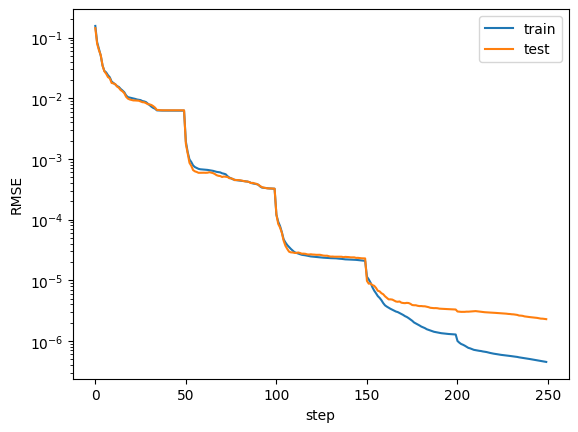

In [6]:
plt.plot(train_losses)
plt.plot(test_losses)
plt.legend(['train', 'test'])
plt.ylabel('RMSE')
plt.xlabel('step')
plt.yscale('log')

Neural scaling laws

Text(0, 0.5, 'RMSE')

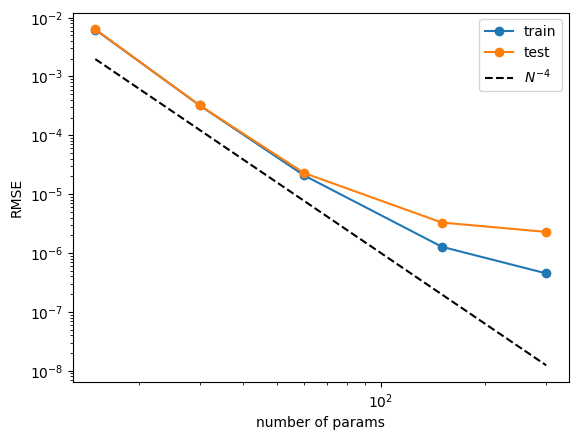

In [7]:
n_params = 3 * grids
train_vs_G = train_losses[(steps-1)::steps]
test_vs_G = test_losses[(steps-1)::steps]
plt.plot(n_params, train_vs_G, marker="o")
plt.plot(n_params, test_vs_G, marker="o")
plt.plot(n_params, 100*n_params**(-4.), ls="--", color="black")
plt.xscale('log')
plt.yscale('log')
plt.legend(['train', 'test', r'$N^{-4}$'])
plt.xlabel('number of params')
plt.ylabel('RMSE')

In [8]:
lib = ['x','x^2','x^3','x^4','exp','log','sqrt','tanh','sin','tan','abs']
model.auto_symbolic(lib=lib)

fixing (0,0,0) with sin, r2=0.9999999993229945
fixing (0,1,0) with x^2, r2=0.9999999999921813
fixing (1,0,0) with exp, r2=0.9999999999937289


In [9]:
model.symbolic_formula()

([1.0*exp(1.0*x_2**2 + 1.0*sin(3.14*x_1))], [x_1, x_2])

- Run of base example: iris dataset

In [11]:
# Importing of dataset
from sklearn import datasets
from sklearn.model_selection import train_test_split

iris = datasets.load_iris()

data    = torch.from_numpy(iris['data'])

target = np.zeros((np.size(iris['target']), 3))

target[iris['target'] == 0, 0] = 1
target[iris['target'] == 1, 1] = 1
target[iris['target'] == 2, 2] = 1

target = torch.from_numpy(target)

X_train, X_test, y_train, y_test = train_test_split(data, target, test_size= 0.2, random_state= 42)

In [12]:
# Initialization of model: coarse grinding
model_coarse = KAN(width=[4,3,3], grid=2, k=3)

# Initialization of model: fine grinding
model_fine  = KAN(width=[4,3,3], grid=10, k=3)

In [13]:
# Creating of dataset:
dataset['train_input'] = X_train; dataset['test_input']  = X_test
dataset['train_label'] = y_train; dataset['test_label']  = y_test

In [14]:
# training of coarse model
model_coarse.train(dataset, opt="LBFGS", steps=30);

train loss: 1.06e-01 | test loss: 8.88e-02 | reg: 1.96e+01 : 100%|██| 30/30 [00:09<00:00,  3.26it/s]


In [15]:
# training of fine model
model_fine.train(dataset, opt="LBFGS", steps=30);

train loss: 1.14e-02 | test loss: 2.02e-01 | reg: 1.51e+01 : 100%|██| 30/30 [00:13<00:00,  2.25it/s]


In [16]:
model_fine_deep = KAN(width=[4,4,3,3,3], grid=3, k=3)

model_fine_deep.train(dataset, opt="LBFGS", steps=30);

description:   0%|                                                           | 0/30 [00:00<?, ?it/s]

train loss: 3.12e-02 | test loss: 8.25e-02 | reg: 3.73e+01 : 100%|██| 30/30 [00:23<00:00,  1.27it/s]


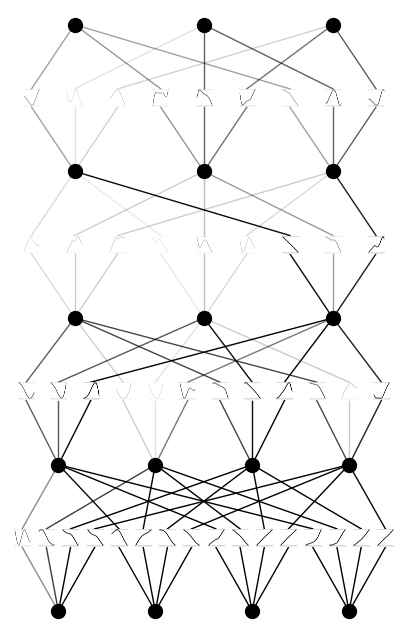

In [17]:
model_fine_deep.plot(beta=10)

In [19]:
# Model mathematical formulation
lib = ['x','x^2','x^3','x^4','exp','log','sqrt','tanh','sin','tan','abs']
model_coarse.auto_symbolic(lib=lib);

formula = model_coarse.symbolic_formula()[0]

fixing (0,0,0) with sin, r2=0.9999753682630023
fixing (0,0,1) with tanh, r2=0.9967064278541601
fixing (0,0,2) with abs, r2=0.9999988196499524
fixing (0,1,0) with sin, r2=0.9999791709325063
fixing (0,1,1) with sin, r2=0.9998669339520958
fixing (0,1,2) with sin, r2=0.9995197711522749
fixing (0,2,0) with sin, r2=0.995063661014041
fixing (0,2,1) with exp, r2=0.9995216462064327
fixing (0,2,2) with x^2, r2=0.9959416350690548
fixing (0,3,0) with tanh, r2=0.9992416358177597
fixing (0,3,1) with tanh, r2=0.9978594255688953
fixing (0,3,2) with tanh, r2=0.9998630985226945
fixing (1,0,0) with sin, r2=0.9816175258139017
fixing (1,0,1) with sin, r2=0.960382204803598
fixing (1,0,2) with tanh, r2=0.9622247059509271
fixing (1,1,0) with sin, r2=0.9867454186350336
fixing (1,1,1) with sin, r2=0.9767689332105769
fixing (1,1,2) with sin, r2=0.9668653243177578
fixing (1,2,0) with sin, r2=0.9993010032600913
fixing (1,2,1) with sin, r2=0.9982016566068682
fixing (1,2,2) with tanh, r2=0.9980764527330322


In [21]:
formula_1 = formula[0]
formula_2 = formula[1]
formula_3 = formula[2]

In [26]:
formula_1

-0.51*sin(2.39*(1 - 0.2*x_3)**2 + 0.31*sin(1.99*x_2 + 1.03) - 2.03*tanh(0.95*x_4 - 0.87) + 0.02*Abs(10.0*x_1 - 3.6) - 11.27) + 0.02*sin(-0.3*exp(0.36*x_3) + 1.7*sin(0.62*x_2 - 1.46) + 0.66*tanh(1.44*x_1 - 7.4) - 1.13*tanh(2.12*x_4 - 1.16) + 12.57) + 0.01*sin(-2.21*sin(0.39*x_1 - 2.76) + 1.58*sin(1.15*x_2 + 5.96) - 2.99*sin(0.8*x_3 + 5.38) + 2.29*tanh(2.12*x_4 - 3.3) + 1.21) + 0.5

In [27]:
# Import simpy for interactions with the formula
import sympy as sp

x_1, x_2, x_3, x_4 = sp.symbols("x_1 x_2 x_3 x_4")

# Now let's use this formula!
f_1 = sp.lambdify([x_1, x_2, x_3, x_4], formula_1)
f_1 = np.vectorize(f_1)
f_2 = sp.lambdify([x_1, x_2, x_3, x_4], formula_2)
f_2 = np.vectorize(f_2)
f_3 = sp.lambdify([x_1, x_2, x_3, x_4], formula_3)
f_3 = np.vectorize(f_3)

In [32]:
y_test_model_1 = f_1(X_test[:, 0], X_test[:, 1], X_test[:, 2], X_test[:, 3])
y_test_model_2 = f_2(X_test[:, 0], X_test[:, 1], X_test[:, 2], X_test[:, 3])
y_test_model_3 = f_3(X_test[:, 0], X_test[:, 1], X_test[:, 2], X_test[:, 3])

In [39]:
# Testing results: Raw data analysis
y_test_error = abs(y_test[:, 0] - y_test_model_1) + abs(y_test[:, 1] - y_test_model_2) + abs(y_test[:, 2] - y_test_model_3)

# Error definitions
error_abs = np.linalg.norm(y_test_error)
error_rel = error_abs / np.linalg.norm(y_test)

print(f"Error absoluto: {error_abs}, Error relativo: {error_rel}")

Error absoluto: 1.4989375773518896, Error relativo: 0.2736673078025916


In [84]:
# Binary scoring results:
from sklearn.metrics import accuracy_score

y_pred_models = np.vstack((y_test_model_1, y_test_model_2, y_test_model_3)).T

y_pred = np.zeros_like(y_pred_models)

y_pred[y_pred_models > 0.5] = 1

accuracy_score(y_pred, y_test)

1.0